<a href="https://colab.research.google.com/github/codesongs/codestates_TP2/blob/main/AE_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_%EA%B0%84%EB%8B%A8%EA%B0%9C%EB%9F%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tp2'

Mounted at /content/drive


In [ ]:
# 데이터 가져오기
import os
import pandas as pd

def load_ratings(path):
    COL_NAME = ['userId','movieId','rating','timestamp']
    df = pd.read_csv(os.path.join(path,"ratings.dat"),sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies(path):
    COL_NAME = ['movieId','title','genres']
    df = pd.read_csv(os.path.join(path,"movies.dat"),sep='::', header=None, engine='python', names=COL_NAME, encoding = 'ISO-8859-1' )
    return df

def load_users(path):
    COL_NAME = ['userId','gender','age','Occupation','zip_code']
    df = pd.read_csv(os.path.join(path,"users.dat"),sep='::', header=None, engine='python', names=COL_NAME)
    return df

In [ ]:
df_ratings = load_ratings(path)
df_movies = load_movies(path)
df_users = load_users(path)

In [ ]:
# 학습용 행렬 생성
user_movie_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.optimizers import Adam

# def masked_mse(y_true, y_pred):
#     mask = tf.math.not_equal(y_true, 0)
#     squared_error = tf.square(y_true - y_pred)
#     return tf.reduce_sum(squared_error * tf.cast(mask, dtype=tf.float32)) / tf.reduce_sum(tf.cast(mask, dtype=tf.float32))

# input_layer = Input(shape=(user_movie_matrix.shape[1],))
# encoded = Dense(512, activation='relu')(input_layer)
# encoded = Dense(256, activation='relu')(encoded)
# decoded = Dense(512, activation='relu')(encoded)
# output_layer = Dense(user_movie_matrix.shape[1])(decoded)

# autoencoder = Model(input_layer, output_layer)
# autoencoder.compile(optimizer=Adam(), loss=masked_mse)

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0)
    squared_error = tf.square(y_true - y_pred)
    return tf.reduce_sum(squared_error * tf.cast(mask, dtype=tf.float32)) / tf.reduce_sum(tf.cast(mask, dtype=tf.float32))

input_layer = Input(shape=(user_movie_matrix.shape[1],))

# Encoder
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dropout(0.5)(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
output_layer = Dense(user_movie_matrix.shape[1])(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss=masked_mse)


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import Callback

def ndcg_score(y_true, y_pred, k=20):
    y_true = np.asarray(y_true)
    y_pred_argsorted = np.argsort(y_pred)[::-1]
    y_pred_sorted = np.take(y_true, y_pred_argsorted[:k])
    ideal_sorted = np.sort(y_true)[::-1][:k]

    dcg = np.sum((2**y_pred_sorted - 1) / np.log2(np.arange(1, k + 1) + 1))
    idcg = np.sum((2**ideal_sorted - 1) / np.log2(np.arange(1, k + 1) + 1))
    if idcg == 0:
        return 0
    return dcg / idcg

def recall_at_k(y_true, y_pred, k=20):
    y_true_set = set(np.where(y_true > 0)[0])
    y_pred_top_k = set(np.argsort(y_pred)[-k:])
    return len(y_true_set & y_pred_top_k) / float(len(y_true_set))

class NDCGRecallCallback(Callback):
    def __init__(self, X_train, k=20):
        super(NDCGRecallCallback, self).__init__()
        self.X_train = X_train
        self.k = k
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        predicted_ratings = self.model.predict(self.X_train)

        ndcg_scores = []
        recall_scores = []
        for idx, user_ratings in enumerate(self.X_train):
            ndcg_scores.append(ndcg_score(user_ratings, predicted_ratings[idx]))
            recall_scores.append(recall_at_k(user_ratings, predicted_ratings[idx], k=self.k))

        avg_ndcg_score = np.mean(ndcg_scores)
        avg_recall_score = np.mean(recall_scores)
        self.losses.append(logs['loss'])

        print(f"\nEpoch {epoch+1} - avg_ndcg@{self.k}: {avg_ndcg_score:.4f} - avg_recall@{self.k}: {avg_recall_score:.4f}")

# Instantiate the callback
X_train = user_movie_matrix.values
ndcg_recall_callback = NDCGRecallCallback(X_train)


In [ ]:
X_train = user_movie_matrix.values
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, shuffle=True, callbacks=[ndcg_recall_callback])

Epoch 1/50
189/189 [==============================] - 3s 18ms/step

Epoch 1 - avg_ndcg@20: 0.0044 - avg_recall@20: 0.0011
48/48 [==============================] - 13s 272ms/step - loss: 1.2412
Epoch 2/50
189/189 [==============================] - 2s 11ms/step

Epoch 2 - avg_ndcg@20: 0.0030 - avg_recall@20: 0.0007
48/48 [==============================] - 11s 240ms/step - loss: 1.2249
Epoch 3/50
189/189 [==============================] - 2s 9ms/step

Epoch 3 - avg_ndcg@20: 0.0100 - avg_recall@20: 0.0014
48/48 [==============================] - 11s 224ms/step - loss: 1.1789
Epoch 4/50
189/189 [==============================] - 2s 12ms/step

Epoch 4 - avg_ndcg@20: 0.0070 - avg_recall@20: 0.0012
48/48 [==============================] - 16s 332ms/step - loss: 1.1378
Epoch 5/50
189/189 [==============================] - 2s 9ms/step

Epoch 5 - avg_ndcg@20: 0.0210 - avg_recall@20: 0.0038
48/48 [==============================] - 12s 245ms/step - loss: 1.1246
Epoch 6/50
189/189 [=================

In [ ]:
# Epoch 36 - avg_ndcg@20: 0.0928 - avg_recall@20: 0.0225 loss: 0.8643

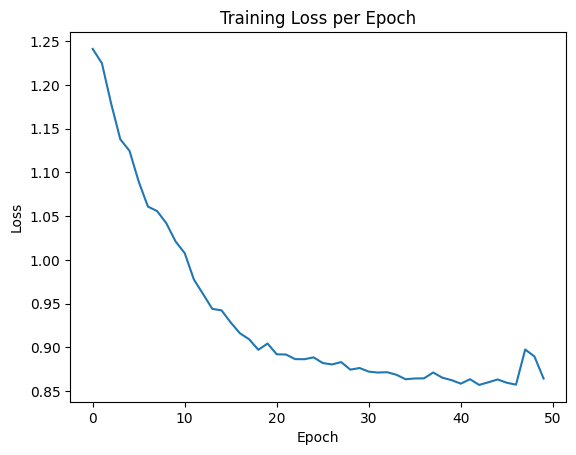

In [ ]:
import matplotlib.pyplot as plt

# 학습 코드 수행...

# 그래프 출력 코드
plt.plot(ndcg_recall_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()

In [ ]:
def recommend_movies(user_id, top_k=20):
    user_idx = user_movie_matrix.index.get_loc(user_id)
    predicted_ratings = autoencoder.predict(np.expand_dims(user_movie_matrix.values[user_idx], axis=0))
    user_ratings = user_movie_matrix.values[user_idx]

    # 시청하지 않은 영화만 추천하기 위한 마스크 생성
    mask = user_ratings == 0
    masked_predictions = predicted_ratings[0] * mask

    # 상위 top_k 영화 추천
    recommended_movie_ids = np.argsort(masked_predictions)[::-1][:top_k]
    recommended_movie_ratings = np.sort(masked_predictions)[::-1][:top_k]

    recommended_df = df_movies[df_movies['movieId'].isin(recommended_movie_ids)].copy()  # DataFrame 복사
    recommended_df['predicted_rating'] = recommended_movie_ratings  # 예측 평점 칼럼 추가

    return recommended_df


In [ ]:
recommend_movies(53, 20)

1/1 [==============================] - 0s 32ms/step


,movieId,title,genres,predicted_rating
50,51,Guardian Angel (1994),Action|Drama|Thriller,5.507176
539,543,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller,4.885773
560,564,Chasers (1994),Comedy,4.751234
580,584,I Don't Want to Talk About It (De eso no se ha...,Drama,4.742983
734,744,Brothers in Trouble (1995),Drama,4.737019
914,926,All About Eve (1950),Drama,4.728823
1052,1066,Shall We Dance? (1937),Comedy|Musical|Romance,4.696373
1074,1090,Platoon (1986),Drama|War,4.636506
1098,1114,"Funeral, The (1996)",Drama,4.634333
1300,1320,Alien³ (1992),Action|Horror|Sci-Fi|Thriller,4.615702


In [ ]:
# 'movieId'와 'userId'를 기준으로 데이터프레임 통합
df_total = pd.merge(df_ratings, df_movies, on='movieId', how='left')
df_total = pd.merge(df_total, df_users, on='userId', how='left')

# 결과 확인
df_total

,userId,movieId,rating,timestamp,title,genres,gender,age,Occupation,zip_code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),Comedy,M,25,6,11106
1000205,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War,M,25,6,11106
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama,M,25,6,11106
1000207,6040,1096,4,956715648,Sophie's Choice (1982),Drama,M,25,6,11106


In [ ]:
np.mean(df_total[df_total.title=='Red Firecracker, Green Firecracker (1994)'].rating)

3.6875

In [ ]:
df_total[df_total.title=='Red Firecracker, Green Firecracker (1994)']

,userId,movieId,rating,timestamp,title,genres,gender,age,Occupation,zip_code
7746,53,309,3,977987956,"Red Firecracker, Green Firecracker (1994)",Drama,M,25,0,96931
51163,337,309,4,976349769,"Red Firecracker, Green Firecracker (1994)",Drama,M,18,19,80205
53787,352,309,3,976333673,"Red Firecracker, Green Firecracker (1994)",Drama,M,18,4,60115
67069,451,309,5,976416423,"Red Firecracker, Green Firecracker (1994)",Drama,M,56,13,54720
150106,966,309,3,975116130,"Red Firecracker, Green Firecracker (1994)",Drama,M,56,2,92262
153714,987,309,2,978279641,"Red Firecracker, Green Firecracker (1994)",Drama,F,35,17,48098
168612,1069,309,4,974943897,"Red Firecracker, Green Firecracker (1994)",Drama,M,25,20,98105
200212,1229,309,4,974836780,"Red Firecracker, Green Firecracker (1994)",Drama,F,25,4,48219
236742,1437,309,4,974759744,"Red Firecracker, Green Firecracker (1994)",Drama,M,50,3,89102
250259,1508,309,1,974748182,"Red Firecracker, Green Firecracker (1994)",Drama,F,1,10,94539
